In [1]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 2.2 MB/s            


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [10]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.0


In [11]:
df = pd.read_csv('training_data.csv')

In [12]:
df.tail()

,base_speed,distance_from_wall,rotation_angle,distance_setpoint,docking_time,docking_distance
43,2.5,603.075973,0.010256,500.0,6.054141,1049.0
44,2.5,630.000000,0.000000,500.0,11.070061,1690.0
45,2.5,426.184890,-0.505791,500.0,9.928071,1460.0
46,2.5,531.331454,0.389317,500.0,11.652685,1701.0
47,2.5,671.474343,0.380506,500.0,9.062397,1432.0


In [65]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

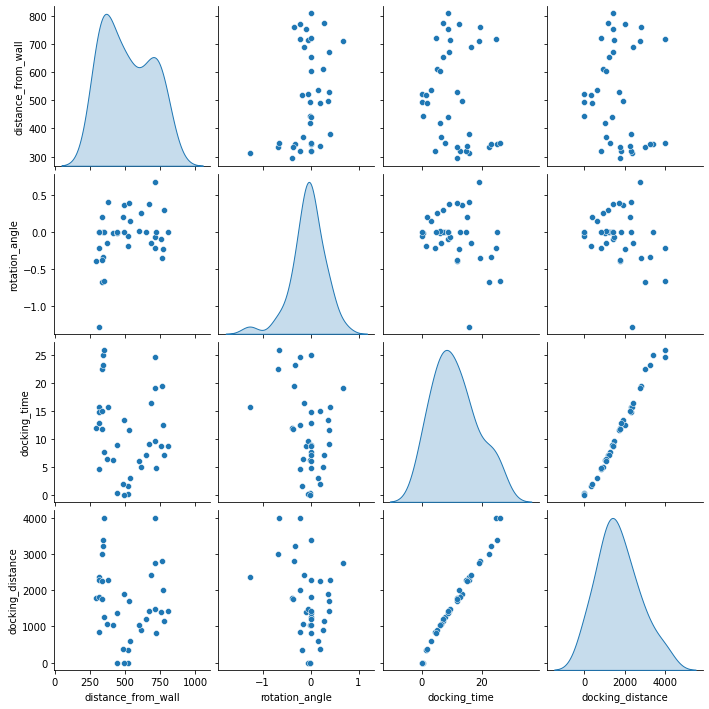

In [66]:
plot=sns.pairplot(train_dataset[[ 
                            # 'base_speed',
                            'distance_from_wall', 
                            'rotation_angle', 
                            # 'distance_setpoint', 
                            'docking_time', 
                            'docking_distance']], 
                            diag_kind='kde'
                            )

In [67]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
base_speed,38.0,2.500000,0.000000,2.500000,2.500000,2.500000,2.500000,2.500000
distance_from_wall,38.0,514.894967,170.074067,292.993785,346.156783,495.939912,684.934576,809.669805
rotation_angle,38.0,-0.055673,0.346780,-1.271073,-0.209658,-0.002564,0.117051,0.677860
distance_setpoint,38.0,500.000000,0.000000,500.000000,500.000000,500.000000,500.000000,500.000000
docking_time,38.0,11.002662,7.331200,0.000599,6.068294,9.296343,15.497448,25.983634
docking_distance,38.0,1669.315789,1037.094775,0.000000,1034.750000,1457.000000,2285.250000,4000.000000


In [68]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('docking_distance')
t=train_features.pop('docking_time')

test_labels = test_features.pop('docking_distance')
t=test_features.pop('docking_time')

# Normalization

In [69]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
base_speed,2.500000,0.000000
distance_from_wall,514.894967,170.074067
rotation_angle,-0.055673,0.346780
distance_setpoint,500.000000,0.000000
docking_time,11.002662,7.331200
docking_distance,1669.315789,1037.094775


In [70]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [71]:
normalizer.adapt(np.array(train_features))

In [121]:
print(normalizer.mean.numpy())

[[  2.5   514.895  -0.056 500.   ]]


# Regression with a deep neural network (DNN)

In [72]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2500])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [152]:
def build_and_compile(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'), 
        layers.Dense(128, activation='relu'), 
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

    return model

## Multiple inputs

In [153]:
dnn_model = build_and_compile(normalizer)
dnn_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_95 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_96 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_97 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_98 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_99 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_100 (Dense)            (None, 1)               

In [154]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=550)

CPU times: user 12.7 s, sys: 1.43 s, total: 14.1 s
Wall time: 11.4 s


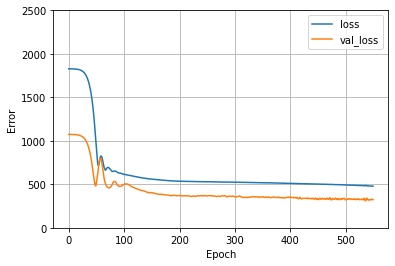

In [155]:
plot_loss(history)

In [156]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
print(test_results['dnn_model'])

527.1953125


# Make predictions

In [159]:
test_predictions = dnn_model.predict(test_features).flatten()

test_predictions = np.array(test_predictions)
test_labels = np.array(list(test_labels))


print(test_predictions)
print(test_labels)

errors = (test_predictions - test_labels)/10

print(errors)

# a = plt.axes(aspect='equal')
# plt.scatter(test_labels, test_predictions)
# plt.xlabel('True Values [Docking Distance]')
# plt.ylabel('Predictions [Docking Distance]')
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

[2111.003 1003.294 3519.636 1621.624  957.356  782.079 1840.973  437.552
  702.15  1684.342]
[1356. 1010. 2698. 2006.  960. 2245. 1870. 1035. 1690. 1460.]
[  75.5     -0.671   82.164  -38.438   -0.264 -146.292   -2.903  -59.745
  -98.785   22.434]
